This notebook reproduces Figure 1d in [Causal evidence of a line attractor encoding an affective state](https://www.nature.com/articles/s41586-024-07915-x) using data from [Dandiset 001037](https://dandiarchive.org/dandiset/001037?search=001037&pos=1).

It is intended to be ingested by Neurosift AI assistant.

Pip requirements:
lindi
pynwb
matplotlib

In [1]:
import pynwb
import lindi
import matplotlib.pyplot as plt

In [34]:
# Load the NWB file from the remote DANDI location
# https://neurosift.app/?p=/nwb&url=https://api.dandiarchive.org/api/assets/1e7b9610-ef6a-4d21-a256-15449d8fbee0/download/&dandisetId=001037&dandisetVersion=0.240816.1841
url = 'https://api.dandiarchive.org/api/assets/1e7b9610-ef6a-4d21-a256-15449d8fbee0/download/'
f = lindi.LindiH5pyFile.from_hdf5_file(url)
io = pynwb.NWBHDF5IO(file=f, mode='r')
nwbfile = io.read()

In [35]:
# Load the neural trace data
# This is a 2D array with shape (num_samples, num_neurons)
neural_trace = nwbfile.get_processing_module('ophys').get_data_interface('NeuralTrace')
neural_trace_timestamps = neural_trace.get_timestamps()
neural_trace_data = neural_trace.data[:]

In [36]:
# Load latent factor weights - these have length equal to the number of neurons
latent_factor_1 = nwbfile.analysis['rSLDS']['latent factor 1'].data[:]
latent_factor_2 = nwbfile.analysis['rSLDS']['latent factor 2'].data[:]

In [37]:
# Load the epochs data
epochs_data = nwbfile.processing['behavior']['BehavioralEpochs']['Ch1: Balc in cage'].data[:]
epochs_timestamps = nwbfile.processing['behavior']['BehavioralEpochs']['Ch1: Balc in cage'].timestamps[:]

# epochs_data is [1, -1, 1, -1, ...], 1 marks the start of a new epoch, -1 marks the end of an epoch
# epochs_timestamps is the same length as epochs_data, and contains the timestamps for each epoch transition

In [38]:
# Compute the activity factors - the neural trace data multiplied by the latent factors
activity_factor_1 = neural_trace_data @ latent_factor_1
activity_factor_2 = neural_trace_data @ latent_factor_2

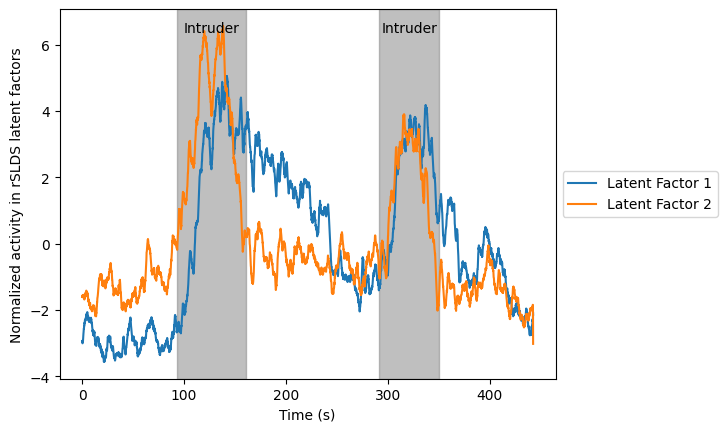

In [39]:
# Plot the activity factors, with gray regions indicating the epochs
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(neural_trace_timestamps, activity_factor_1, label='Latent Factor 1')
ax.plot(neural_trace_timestamps, activity_factor_2, label='Latent Factor 2')

for i in range(0, len(epochs_data), 2):
    ax.axvspan(epochs_timestamps[i], epochs_timestamps[i+1], color='gray', alpha=0.5)
    mid_point = (epochs_timestamps[i] + epochs_timestamps[i+1]) / 2
    ax.text(mid_point, ax.get_ylim()[1] * 0.9, 'Intruder', horizontalalignment='center', color='black')

ax.yaxis.set_label_text('Normalized activity in rSLDS latent factors')
ax.xaxis.set_label_text('Time (s)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()